In [1]:
import torch

if torch.backends.mps.is_available():
    print("✅ MPS (Metal) backend is available and enabled.")
else:
    print("❌ MPS not available.")

✅ MPS (Metal) backend is available and enabled.


#### **Table of Contents**

**Preface**
**List of Figures**
**List of Algorithms**

### **Part I: The Adaptive Learning Paradigm**

**Chapter 1. A Baseline for Personalization: The Batched Learning Approach**

1.1. Introduction: The Personalization Challenge
  - 1.1.1. The E-commerce Context: A Case Study of Zooplus
  - 1.1.2. Defining Success: Click-Through Rate (CTR) as a Proxy for Engagement
1.2. The Proving Ground: Simulating a Realistic User Environment
  - 1.2.1. The Need for Offline Experimentation
  - 1.2.2. Core Components: Product Catalogs, User Personas, and the Reward Function
  - 1.2.3. Implementation: The `ZooplusSimulator` Class
1.3. The Baseline Model: An Embedding+MLP Recommender
  - 1.3.1. The Philosophy of Batched Learning from Historical Logs
  - 1.3.2. Generating a Static Training Dataset
  - 1.3.3. Architectural Deep Dive: Embeddings, Concatenation, and the MLP Tower
  - 1.3.4. Implementation and Training in PyTorch
1.4. Critical Analysis: Inherent Flaws of the Batched Paradigm
  - 1.4.1. The Cold-Start Problem for New Users and Items
  - 1.4.2. Inertia: Inability to Adapt to Non-Stationary Preferences
  - 1.4.3. The Feedback Loop and the Absence of Exploration
1.5. Chapter Summary and Transition to Online Learning

**Chapter 2. The Adaptive Recommender: Contextual Bandits in Action**

2.1. Introduction: Escaping the Static World with the Explore-Exploit Dilemma
2.2. The Frontier Technique: Linear Upper Confidence Bound (LinUCB)
  - 2.2.1. Theoretical Foundations: The Contextual Bandit Problem
  - 2.2.2. The Linear Reward Assumption
  - 2.2.3. Deriving the UCB Score: Balancing Exploitation and Uncertainty
  - 2.2.4. The Disjoint Model Architecture: Parameters $A_a$ and $b_a$
2.3. Implementation: Building the `LinUCBAgent`
  - 2.3.1. The Role of Feature Engineering for Context
  - 2.3.2. The `predict` and `update` Methods
2.4. The Online Arena: A Head-to-Head Simulation
  - 2.4.1. Comparing LinUCB vs. the Batched MLP in a Stationary Environment
  - 2.4.2. Analysis of Performance and Cumulative Regret
2.5. The True Test: The Market Shock Experiment
  - 2.5.1. Modeling a Non-Stationary World: Shifting User Preferences
  - 2.5.2. Visualizing Adaptation: How LinUCB Responds to Change
2.6. Critical Analysis and Transition: The Limits of Disjoint Models

**Chapter 3. Neural Contextual Bandits: Generalization Through Shared Representation**

3.1. The Need for Generalization: From Disjoint to Shared Models
3.2. NeuralUCB: Theory and Formulation
  - 3.2.1. Generalizing the UCB Principle Beyond Linearity
  - 3.2.2. Approximating Confidence Bounds with Output-Parameter Gradients
  - 3.2.3. The Power of Shared Parameters: A Single Model for All Arms
3.3. Implementation Part I: The Neural Function Approximator
  - 3.3.1. Architectural Design of the `NeuralBanditNetwork` in PyTorch
  - 3.3.2. Remark: The Deliberate Absence of a Final Sigmoid Activation
3.4. Implementation Part II: The `NeuralUCBAgent`
  - 3.4.1. The Agent's Architecture: Model, UCB Machinery, and Optimizer
  - 3.4.2. The Predict-and-Update Cycle
3.5. A Pedagogical Deep Dive: Scaling to Millions of Arms
  - 3.5.1. The "K-Pass Problem": Identifying the Computational Bottleneck
  - 3.5.2. The Vectorized Solution via the Output-Parameter Jacobian
  - 3.5.3. Implementation with `torch.func.vmap`
  - 3.5.4. Analysis: The Time vs. Memory Trade-off
  - 3.5.5. Outlook: The Two-Stage Architecture for Industrial-Scale Systems
3.6. Chapter Summary and Future Directions

### **Part II: Advanced Architectures and Modalities**

**Chapter 4. The Session-Aware Recommender: Sequential Models for In-the-Moment Personalization (Forthcoming)**

4.1. Introduction: Beyond the Static Context
4.2. The Frontier Technique: Transformer Architectures for Recommendation
4.3. Building a Behavioral Sequence Transformer (BST)
4.4. Training, Evaluation, and the Challenge of Long Sequences

**Chapter 5. Learning from the Crowd: Graph-Based Personalization (Forthcoming)**

5.1. Introduction: The Power of Collaborative Signals
5.2. The Frontier Technique: Graph Convolutional Networks (GCNs)
5.3. Implementing LightGCN for Collaborative Filtering
5.4. Generating Recommendations from Learned Graph Embeddings

**Conclusion: Towards Hybrid Recommender Systems**

**Appendices**
**Bibliography**
**Index**


## **Part I: From Static Predictions to Adaptive Learning**

### **Chapter 1: Personalization in Practice: A Batched Learning Baseline**

#### **1.1 Introduction: The Personalization Challenge at Zooplus**

Welcome. In this book, we will embark on a journey to the frontiers of modern recommendation systems. Our goal is not simply to understand these systems in the abstract, but to build them, piece by piece, developing the intuition and practical skills required to deploy them in the real world. Our laboratory for this journey will be a simulated version of a large-scale e-commerce platform: **Zooplus**, Europe's leading online retailer for pet supplies.

Imagine a user, let's call her Anna, who has just adopted a German Shepherd puppy. She visits Zooplus for the first time. What should the website show her on its homepage? A generic list of "bestselling products"? This might include premium cat food and bird cages—items that are popular overall but completely irrelevant to Anna. This is a missed opportunity. A truly intelligent system would infer, perhaps from her first few clicks, that she is a new puppy owner and immediately start personalizing her experience, surfacing puppy-specific food, durable chew toys, and training pads.

This is the essence of personalization: **the process of tailoring an experience to the specific needs, preferences, and context of an individual user.** For an e-commerce site like Zooplus, effective personalization is not a luxury; it is the engine of user engagement, customer loyalty, and ultimately, commercial success. Our core objective will be to build systems that maximize a key proxy for engagement: the **click-through rate (CTR)**, or the probability that a user will click on a recommended item.

Over the next two chapters, we will construct and contrast two fundamentally different approaches to this problem. In this chapter, we will begin by building a strong, industry-standard baseline: a deep learning model trained on a static, historical log of user interactions. This "batched" approach is a powerful workhorse, but as we will see, it suffers from critical flaws. It is slow to adapt, blind to new products, and incapable of intelligent exploration.

Understanding these limitations will motivate our leap, in Chapter 2, to a more dynamic and intelligent paradigm: the **contextual bandit**. This will be our first foray into reinforcement learning, where our system learns continuously from every single user interaction, intelligently balancing the need to exploit known preferences with the drive to explore new possibilities. Let us begin by creating the world in which our algorithms will live.

#### **1.2 The Proving Ground: Simulating a Realistic User Environment**

Before we can write a single line of a recommendation algorithm, we face a fundamental problem. The most advanced personalization techniques, such as the bandits we will soon study, are *online* algorithms. They are designed to learn interactively, in real-time, with live users. We cannot, of course, experiment directly on Zooplus's production systems. Doing so would be costly, risky, and slow.

The solution is to build a **simulation**: a digital replica of the user-item interaction environment. A well-designed simulation provides a safe, fast, and repeatable "proving ground" where we can deploy, test, and compare our algorithms. It allows us to run thousands of interactions in seconds and to rigorously evaluate how well an algorithm learns over time.

Our simulation must be simple enough to be tractable, yet realistic enough to be meaningful. It will consist of three core components:

1.  **A Product Catalog:** A collection of items that can be recommended. Each item will have attributes, such as its category.
2.  **User Personas:** We will not model a single, "average user." Real-world user populations are heterogeneous. We will define distinct personas (e.g., "The Cat Connoisseur," "The New Puppy Parent") with different underlying preferences.
3.  **An Interaction Model (The Reward Function):** The logic that determines the outcome (a click or no-click) when a specific user is shown a specific product. Crucially, this model must be **stochastic** (i.e., contain randomness) to reflect the inherent noise and unpredictability of human behavior.

Let's build this simulation in Python.

**Code Block 1.1: The Zooplus Simulation Environment**
```python
import numpy as np
import pandas as pd

class ZooplusSimulator:
    """
    A simulated environment for the Zooplus recommendation problem.

    This class manages:
    1. A product catalog with features (category).
    2. A set of user personas with distinct preferences.
    3. A stochastic reward function to simulate user clicks (CTR).
    """
    def __init__(self, n_products=50, n_users=1000, seed=42):
        """
        Initializes the simulation environment.
        
        Args:
            n_products (int): The total number of products in the catalog.
            n_users (int): The total number of unique users in the simulation.
            seed (int): Random seed for reproducibility.
        """
        self.rng = np.random.default_rng(seed)
        self.n_products = n_products
        self.n_users = n_users
        
        # 1. Create the Product Catalog
        self.products = self._create_product_catalog()
        
        # 2. Create User Personas and assign each of the n_users to a persona
        self.personas = self._create_user_personas()
        self.user_to_persona_map = self._assign_users_to_personas()

    def _create_product_catalog(self):
        """Creates a pandas DataFrame of products."""
        product_ids = range(self.n_products)
        # Ensure a balanced representation of categories
        categories = ['Fish Supplies', 'Cat Food', 'Dog Food', 'Dog Toy', 'Cat Toy']
        num_per_category = self.n_products // len(categories)
        cat_list = []
        for cat in categories:
            cat_list.extend([cat] * num_per_category)
        # Fill the remainder, if any
        cat_list.extend(self.rng.choice(categories, self.n_products - len(cat_list)))
        
        product_data = {
            'product_id': product_ids,
            'category': self.rng.permutation(cat_list) # Shuffle categories
        }
        return pd.DataFrame(product_data).set_index('product_id')

    def _create_user_personas(self):
        """Defines a dictionary of user personas and their preferences (base CTRs)."""
        return {
            'new_puppy_parent': {'Dog Food': 0.40, 'Dog Toy': 0.50, 'Cat Food': 0.10, 'Cat Toy': 0.05, 'Fish Supplies': 0.02},
            'cat_connoisseur':  {'Dog Food': 0.05, 'Dog Toy': 0.02, 'Cat Food': 0.55, 'Cat Toy': 0.45, 'Fish Supplies': 0.05},
            'budget_shopper':   {'Dog Food': 0.25, 'Dog Toy': 0.15, 'Cat Food': 0.40, 'Cat Toy': 0.20, 'Fish Supplies': 0.20},
            'fish_hobbyist':    {'Dog Food': 0.02, 'Dog Toy': 0.02, 'Cat Food': 0.10, 'Cat Toy': 0.08, 'Fish Supplies': 0.60}
        }
        
    def _assign_users_to_personas(self):
        """Randomly assigns each user ID to one of the defined personas."""
        persona_names = list(self.personas.keys())
        return {user_id: self.rng.choice(persona_names) for user_id in range(self.n_users)}

    def get_true_ctr(self, user_id, product_id):
        """Returns the ground-truth, noise-free click probability."""
        if user_id not in self.user_to_persona_map or product_id not in self.products.index:
            return 0.0
            
        persona_name = self.user_to_persona_map[user_id]
        persona_prefs = self.personas[persona_name]
        
        product_category = self.products.loc[product_id, 'category']
        
        # The true CTR is directly from the persona's preferences for that category
        click_prob = persona_prefs.get(product_category, 0.01) # Default for unknown categories
        return click_prob

    def get_reward(self, user_id, product_id):
        """
        Simulates a user-item interaction and returns a stochastic reward (1 for click, 0 for no-click).
        """
        click_prob = self.get_true_ctr(user_id, product_id)
        
        # Sample from a Bernoulli distribution to get a stochastic outcome
        # This simulates the inherent randomness of a user's click decision
        reward = self.rng.binomial(1, click_prob)
        return reward

    def get_random_user(self):
        """Returns a random user_id from the population."""
        return self.rng.integers(0, self.n_users)

# --- Instantiate the simulator ---
sim = ZooplusSimulator(seed=42)
print("Simulation Initialized.")
print("\nExample product data:")
print(sim.products.head())
print("\nExample user-persona mapping:")
print({k: sim.user_to_persona_map[k] for k in range(5)})
```
**Dissecting the Simulation:**

*   **`_create_product_catalog`**: This method generates our inventory. We ensure a relatively balanced number of products per category to prevent severe data imbalance issues during training.
*   **`_create_user_personas`**: Here we define the "ground truth" of our users' tastes. The values in the dictionary are now the *mean click-through rates*. For example, a `new_puppy_parent` has a 50% chance of clicking on a `Dog Toy` on average. This is the signal our models will try to learn.
*   **`get_reward`**: This is the heart of the simulation. It looks up the true CTR for a given user persona and product category and then performs a single coin flip (`rng.binomial`) weighted by that probability. This is the source of noise. Even if an item has a true CTR of 0.6, the `get_reward` function will return `0` (no click) 40% of the time. This stochasticity is what makes the problem challenging and realistic; user behavior is probabilistic, not deterministic.

With this simulation in hand, we can now generate the historical data needed to train our first model.



In [5]:
import numpy as np
import pandas as pd

class ZooplusSimulator:
    """
    A simulated environment for the Zooplus recommendation problem.

    This class manages:
    1. A product catalog with features (category).
    2. A set of user personas with distinct preferences.
    3. A stochastic reward function to simulate user clicks (CTR).
    """
    def __init__(self, n_products=50, n_users=1000, seed=42):
        """
        Initializes the simulation environment.
        
        Args:
            n_products (int): The total number of products in the catalog.
            n_users (int): The total number of unique users in the simulation.
            seed (int): Random seed for reproducibility.
        """
        self.rng = np.random.default_rng(seed)
        self.n_products = n_products
        self.n_users = n_users
        
        # 1. Create the Product Catalog
        self.products = self._create_product_catalog()
        
        # 2. Create User Personas and assign each of the n_users to a persona
        self.personas = self._create_user_personas()
        self.user_to_persona_map = self._assign_users_to_personas()

    def _create_product_catalog(self):
        """Creates a pandas DataFrame of products."""
        product_ids = range(self.n_products)
        # Ensure a balanced representation of categories
        categories = ['Fish Supplies', 'Cat Food', 'Dog Food', 'Dog Toy', 'Cat Toy']
        num_per_category = self.n_products // len(categories)
        cat_list = []
        for cat in categories:
            cat_list.extend([cat] * num_per_category)
        # Fill the remainder, if any
        cat_list.extend(self.rng.choice(categories, self.n_products - len(cat_list)))
        
        product_data = {
            'product_id': product_ids,
            'category': self.rng.permutation(cat_list) # Shuffle categories
        }
        return pd.DataFrame(product_data).set_index('product_id')

    def _create_user_personas(self):
        """Defines a dictionary of user personas and their preferences (base CTRs)."""
        return {
            'new_puppy_parent': {'Dog Food': 0.40, 'Dog Toy': 0.50, 'Cat Food': 0.10, 'Cat Toy': 0.05, 'Fish Supplies': 0.02},
            'cat_connoisseur':  {'Dog Food': 0.05, 'Dog Toy': 0.02, 'Cat Food': 0.55, 'Cat Toy': 0.45, 'Fish Supplies': 0.05},
            'budget_shopper':   {'Dog Food': 0.25, 'Dog Toy': 0.15, 'Cat Food': 0.40, 'Cat Toy': 0.20, 'Fish Supplies': 0.20},
            'fish_hobbyist':    {'Dog Food': 0.02, 'Dog Toy': 0.02, 'Cat Food': 0.10, 'Cat Toy': 0.08, 'Fish Supplies': 0.60}
        }
        
    def _assign_users_to_personas(self):
        """Randomly assigns each user ID to one of the defined personas."""
        persona_names = list(self.personas.keys())
        return {user_id: self.rng.choice(persona_names) for user_id in range(self.n_users)}

    def get_true_ctr(self, user_id, product_id):
        """Returns the ground-truth, noise-free click probability."""
        if user_id not in self.user_to_persona_map or product_id not in self.products.index:
            return 0.0
            
        persona_name = self.user_to_persona_map[user_id]
        persona_prefs = self.personas[persona_name]
        
        product_category = self.products.loc[product_id, 'category']
        
        # The true CTR is directly from the persona's preferences for that category
        click_prob = persona_prefs.get(product_category, 0.01) # Default for unknown categories
        return click_prob

    def get_reward(self, user_id, product_id):
        """
        Simulates a user-item interaction and returns a stochastic reward (1 for click, 0 for no-click).
        """
        click_prob = self.get_true_ctr(user_id, product_id)
        
        # Sample from a Bernoulli distribution to get a stochastic outcome
        # This simulates the inherent randomness of a user's click decision
        reward = self.rng.binomial(1, click_prob)
        return reward

    def get_random_user(self):
        """Returns a random user_id from the population."""
        return self.rng.integers(0, self.n_users)

# # --- Instantiate the simulator ---
# sim = ZooplusSimulator(seed=42)
# print("Simulation Initialized.")
# print("\nExample product data:")
# print(sim.products.head())
# print("\nExample user-persona mapping:")
# print({k: sim.user_to_persona_map[k] for k in range(5)})
# --- Instantiate the simulator ---
sim = ZooplusSimulator(seed=42)
print("Simulation Initialized.\n")

# --- A More Illustrative Test ---

# 1. Select a persona to test
test_persona = 'new_puppy_parent'

# 2. Find a user with this persona
test_user_id = -1
for user_id, persona in sim.user_to_persona_map.items():
    if persona == test_persona:
        test_user_id = user_id
        break

# 3. Find one relevant product and one irrelevant product
try:
    high_affinity_prod_id = sim.products[sim.products['category'] == 'Dog Toy'].index[0]
    low_affinity_prod_id = sim.products[sim.products['category'] == 'Cat Toy'].index[0]
except IndexError:
    print("Error: Could not find products of the required categories. Rerunning simulation setup.")
    # In a rare case of random assignment, a category might not exist.
    # We can handle this, but for this demo, we assume they exist.
    high_affinity_prod_id, low_affinity_prod_id = 3, 4 # Fallback for notebook consistency

# 4. Simulate many interactions to observe the average CTR
n_trials = 100
high_affinity_clicks = 0
low_affinity_clicks = 0

for _ in range(n_trials):
    high_affinity_clicks += sim.get_reward(test_user_id, high_affinity_prod_id)
    low_affinity_clicks += sim.get_reward(test_user_id, low_affinity_prod_id)

# 5. Report the results and compare to the ground truth
print(f"--- Testing Persona: '{test_persona}' (User ID: {test_user_id}) ---")
print(f"\n1. Interaction with High-Affinity Product (ID: {high_affinity_prod_id}, Category: 'Dog Toy')")
expected_high_ctr = sim.personas[test_persona]['Dog Toy']
observed_high_ctr = high_affinity_clicks / n_trials
print(f"  --> Expected CTR (from persona definition): {expected_high_ctr:.2%}")
print(f"  --> Observed CTR (from {n_trials} simulations): {observed_high_ctr:.2%}")

print(f"\n2. Interaction with Low-Affinity Product (ID: {low_affinity_prod_id}, Category: 'Cat Toy')")
expected_low_ctr = sim.personas[test_persona]['Cat Toy']
observed_low_ctr = low_affinity_clicks / n_trials
print(f"  --> Expected CTR (from persona definition): {expected_low_ctr:.2%}")
print(f"  --> Observed CTR (from {n_trials} simulations): {observed_low_ctr:.2%}")

Simulation Initialized.

--- Testing Persona: 'new_puppy_parent' (User ID: 0) ---

1. Interaction with High-Affinity Product (ID: 4, Category: 'Dog Toy')
  --> Expected CTR (from persona definition): 50.00%
  --> Observed CTR (from 100 simulations): 53.00%

2. Interaction with Low-Affinity Product (ID: 3, Category: 'Cat Toy')
  --> Expected CTR (from persona definition): 5.00%
  --> Observed CTR (from 100 simulations): 6.00%


### **1.3 The Baseline: A Batched Deep Learning Recommender**

Our first approach will be to build a model based on the widely successful **"Embedding + MLP"** pattern. This is a cornerstone of modern deep learning-based recommenders.

The philosophy is straightforward: we will first use our simulator to generate a large, static log of historical interactions—imagine this as the server logs from the past month. Then, we will train a neural network on this "batch" of data to learn to predict the probability of a click for any given `(user, item)` pair.

**Step 1: Generate the Historical Data**

We will run our simulation for a large number of steps. In a real system, the items shown to users would have been selected by a previous (perhaps simpler or even random) recommendation policy. We simulate this by showing a random product to a random user.

**Code Block 1.2: Generating a Batched Dataset**
```python
def generate_training_data(simulator, num_interactions):
    """Generates a historical log of user-item interactions."""
    user_ids, product_ids, clicks = [], [], []
    
    print(f"Generating {num_interactions:,} interaction records...")
    for _ in range(num_interactions):
        user_id = simulator.get_random_user()
        product_id = simulator.rng.integers(0, simulator.n_products)
        
        click = simulator.get_reward(user_id, product_id)
        
        user_ids.append(user_id)
        product_ids.append(product_id)
        clicks.append(click)
        
    df = pd.DataFrame({
        'user_id': user_ids,
        'product_id': product_ids,
        'clicked': clicks
    })
    # Join with product category for later analysis
    df = df.join(simulator.products, on='product_id')
    return df

# Generate a dataset of 200,000 interactions
training_data = generate_training_data(sim, 200_000)
print("\nGenerated Training Data:")
print(training_data.head())
print(f"\nOverall Click-Through Rate (CTR) in dataset: {training_data.clicked.mean():.2%}")
```

This `training_data` DataFrame is now our ground truth. It's a static snapshot of the past. Our task is to build a model that can learn the underlying preference patterns hidden within this noisy data.

In [6]:
def generate_training_data(simulator, num_interactions):
    """Generates a historical log of user-item interactions."""
    user_ids, product_ids, clicks = [], [], []
    
    print(f"Generating {num_interactions:,} interaction records...")
    for _ in range(num_interactions):
        user_id = simulator.get_random_user()
        product_id = simulator.rng.integers(0, simulator.n_products)
        
        click = simulator.get_reward(user_id, product_id)
        
        user_ids.append(user_id)
        product_ids.append(product_id)
        clicks.append(click)
        
    df = pd.DataFrame({
        'user_id': user_ids,
        'product_id': product_ids,
        'clicked': clicks
    })
    # Join with product category for later analysis
    df = df.join(simulator.products, on='product_id')
    return df

# Generate a dataset of 200,000 interactions
training_data = generate_training_data(sim, 200_000)
print("\nGenerated Training Data:")
print(training_data.head())
print(f"\nOverall Click-Through Rate (CTR) in dataset: {training_data.clicked.mean():.2%}")

Generating 200,000 interaction records...

Generated Training Data:
   user_id  product_id  clicked  category
0      209          22        0  Dog Food
1      207          24        0  Dog Food
2      394           7        0   Cat Toy
3        1          20        0   Dog Toy
4      862           5        0  Dog Food

Overall Click-Through Rate (CTR) in dataset: 21.01%


**Step 2: Designing the "Embedding + MLP" Model in PyTorch**

Our model needs to take a `user_id` and a `product_id` as input and output a single number: the predicted CTR. The key is the **embedding layer**. In PyTorch, an `nn.Embedding` layer is a lookup table that maps a sparse identifier (like `user_id`) to a dense vector of learned floating-point numbers.

Our model architecture will be:
1.  **Embedding Layers:** One `nn.Embedding` layer for users and one for products.
2.  **Concatenation:** The resulting user and product vectors are concatenated (`torch.cat`) into a single vector.
3.  **MLP Tower:** This combined vector is passed through a Multi-Layer Perceptron (MLP) of `nn.Linear` layers with ReLU activation to learn complex, non-linear interactions.
4.  **Output Layer:** A final `nn.Linear` layer with a single output neuron, followed by a `torch.sigmoid` activation to constrain the output to a `[0, 1]` probability.

**Code Block 1.3: Building and Training the Batched PyTorch Model**
```python
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

# --- Device Configuration ---
if torch.backends.mps.is_available() and torch.backends.mps.is_built():
    device = torch.device("mps")
    print("Using MPS (Apple Silicon) device.")
elif torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using CUDA device.")
else:
    device = torch.device("cpu")
    print("Using CPU device.")

# --- 1. Define the Dataset Class ---
class RecommenderDataset(Dataset):
    def __init__(self, users, products, labels):
        self.users = torch.tensor(users, dtype=torch.long)
        self.products = torch.tensor(products, dtype=torch.long)
        self.labels = torch.tensor(labels, dtype=torch.float32)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.users[idx], self.products[idx], self.labels[idx]

# --- 2. Define the Model Architecture ---
class MLPRecommender(nn.Module):
    def __init__(self, n_users, n_products, embedding_dim=32):
        super().__init__()
        self.user_embedding = nn.Embedding(n_users, embedding_dim)
        self.product_embedding = nn.Embedding(n_products, embedding_dim)
        self.fc1 = nn.Linear(embedding_dim * 2, 64)
        self.fc2 = nn.Linear(64, 32)
        self.output = nn.Linear(32, 1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, user_ids, product_ids):
        user_embeds = self.user_embedding(user_ids)
        product_embeds = self.product_embedding(product_ids)
        x = torch.cat([user_embeds, product_embeds], dim=1)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.output(x)
        return self.sigmoid(x)

# --- 3. Prepare Data and DataLoaders ---
train_df, val_df = train_test_split(training_data, test_size=0.2, random_state=42)
train_dataset = RecommenderDataset(train_df.user_id.values, train_df.product_id.values, train_df.clicked.values)
val_dataset = RecommenderDataset(val_df.user_id.values, val_df.product_id.values, val_df.clicked.values)
train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=512, shuffle=False)

# --- 4. Instantiate Model, Loss, and Optimizer ---
batch_model = MLPRecommender(n_users=sim.n_users, n_products=sim.n_products).to(device)
criterion = nn.BCELoss() # Binary Cross-Entropy Loss
optimizer = optim.Adam(batch_model.parameters(), lr=0.001)
print("\nPyTorch Model Architecture:")
print(batch_model)

# --- 5. The Training Loop ---
print("\nTraining the batched PyTorch model...")
n_epochs = 5
for epoch in range(n_epochs):
    batch_model.train()
    train_loss = 0
    for users, products, labels in train_loader:
        users, products, labels = users.to(device), products.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = batch_model(users, products).squeeze()
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    
    batch_model.eval()
    val_loss = 0
    with torch.no_grad():
        for users, products, labels in val_loader:
            users, products, labels = users.to(device), products.to(device), labels.to(device)
            outputs = batch_model(users, products).squeeze()
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            
    print(f"Epoch {epoch+1}/{n_epochs}, "
          f"Train Loss: {train_loss/len(train_loader):.4f}, "
          f"Val Loss: {val_loss/len(val_loader):.4f}")

print("\nTraining complete.")
torch.save(batch_model.state_dict(), "batch_recommender_model.pth")
```

We now have a strong baseline model, trained on our static historical data. It has learned to predict CTRs from the noisy log of past interactions. On the surface, it is a powerful, modern recommender. However, its static nature hides deep-seated problems that become apparent as soon as the world changes.



In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

# --- Device Configuration ---
if torch.backends.mps.is_available() and torch.backends.mps.is_built():
    device = torch.device("mps")
    print("Using MPS (Apple Silicon) device.")
elif torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using CUDA device.")
else:
    device = torch.device("cpu")
    print("Using CPU device.")

# --- 1. Define the Dataset Class ---
class RecommenderDataset(Dataset):
    def __init__(self, users, products, labels):
        self.users = torch.tensor(users, dtype=torch.long)
        self.products = torch.tensor(products, dtype=torch.long)
        self.labels = torch.tensor(labels, dtype=torch.float32)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.users[idx], self.products[idx], self.labels[idx]

# --- 2. Define the Model Architecture ---
class MLPRecommender(nn.Module):
    def __init__(self, n_users, n_products, embedding_dim=32):
        super().__init__()
        self.user_embedding = nn.Embedding(n_users, embedding_dim)
        self.product_embedding = nn.Embedding(n_products, embedding_dim)
        self.fc1 = nn.Linear(embedding_dim * 2, 64)
        self.fc2 = nn.Linear(64, 32)
        self.output = nn.Linear(32, 1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, user_ids, product_ids):
        user_embeds = self.user_embedding(user_ids)
        product_embeds = self.product_embedding(product_ids)
        x = torch.cat([user_embeds, product_embeds], dim=1)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.output(x)
        return self.sigmoid(x)

# --- 3. Prepare Data and DataLoaders ---
train_df, val_df = train_test_split(training_data, test_size=0.2, random_state=42)
train_dataset = RecommenderDataset(train_df.user_id.values, train_df.product_id.values, train_df.clicked.values)
val_dataset = RecommenderDataset(val_df.user_id.values, val_df.product_id.values, val_df.clicked.values)
train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=512, shuffle=False)

# --- 4. Instantiate Model, Loss, and Optimizer ---
batch_model = MLPRecommender(n_users=sim.n_users, n_products=sim.n_products).to(device)
criterion = nn.BCELoss() # Binary Cross-Entropy Loss
optimizer = optim.Adam(batch_model.parameters(), lr=0.001)
print("\nPyTorch Model Architecture:")
print(batch_model)

# --- 5. The Training Loop ---
print("\nTraining the batched PyTorch model...")
n_epochs = 10
for epoch in range(n_epochs):
    batch_model.train()
    train_loss = 0
    for users, products, labels in train_loader:
        users, products, labels = users.to(device), products.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = batch_model(users, products).squeeze()
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    
    batch_model.eval()
    val_loss = 0
    with torch.no_grad():
        for users, products, labels in val_loader:
            users, products, labels = users.to(device), products.to(device), labels.to(device)
            outputs = batch_model(users, products).squeeze()
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            
    print(f"Epoch {epoch+1}/{n_epochs}, "
          f"Train Loss: {train_loss/len(train_loader):.4f}, "
          f"Val Loss: {val_loss/len(val_loader):.4f}")

print("\nTraining complete.")
torch.save(batch_model.state_dict(), "batch_recommender_model.pth")

Using MPS (Apple Silicon) device.

PyTorch Model Architecture:
MLPRecommender(
  (user_embedding): Embedding(1000, 32)
  (product_embedding): Embedding(50, 32)
  (fc1): Linear(in_features=64, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (output): Linear(in_features=32, out_features=1, bias=True)
  (relu): ReLU()
  (sigmoid): Sigmoid()
)

Training the batched PyTorch model...
Epoch 1/10, Train Loss: 0.5243, Val Loss: 0.5079
Epoch 2/10, Train Loss: 0.5089, Val Loss: 0.5063
Epoch 3/10, Train Loss: 0.5051, Val Loss: 0.5021
Epoch 4/10, Train Loss: 0.4921, Val Loss: 0.4827
Epoch 5/10, Train Loss: 0.4574, Val Loss: 0.4466
Epoch 6/10, Train Loss: 0.4289, Val Loss: 0.4306
Epoch 7/10, Train Loss: 0.4148, Val Loss: 0.4225
Epoch 8/10, Train Loss: 0.4073, Val Loss: 0.4192
Epoch 9/10, Train Loss: 0.4025, Val Loss: 0.4164
Epoch 10/10, Train Loss: 0.3990, Val Loss: 0.4156

Training complete.


### **1.4 Critical Analysis: The Inherent Flaws of the Batched Approach**

The batched learning paradigm, despite its power, suffers from several fundamental weaknesses that limit its effectiveness in a dynamic e-commerce environment.

**Flaw 1: The Cold-Start Problem**

*   **New Product (Item) Cold Start:** Imagine Zooplus introduces a new brand of hypoallergenic dog food with `product_id=50`. Our trained `MLPRecommender` has no knowledge of this product. Its `product_embedding` layer was defined with a fixed vocabulary size (`n_products=50`). The model is fundamentally incapable of recommending it until we collect substantial interaction data and completely retrain the entire model.
*   **New User Cold Start:** A new user, Anna, registers with `user_id=1000`. Like the new product, she is out-of-vocabulary for our `user_embedding` layer. The model cannot generate personalized predictions for her. We must fall back to a generic strategy, such as recommending global bestsellers, defeating the purpose of personalization.

**Flaw 2: Inability to Adapt to Changing Preferences**

User tastes are not static. A "new puppy parent" eventually becomes a "mature dog owner." Our batched model, trained on historical data, only captures a snapshot of past preferences. It has no mechanism to adapt to these evolving tastes in real-time. The only way to update its knowledge is to wait, collect new data, and periodically retrain the entire system, a process that can take hours or even days, creating a significant lag between a change in user behavior and the system's response.

**Flaw 3: The Feedback Loop and Lack of Exploration**

This is perhaps the most subtle but most damaging flaw. Our model was trained on data where users were shown *random* products. When we deploy this model, it will preferentially show users items it *already believes* they will like. Users will click on these items, generating more positive interaction data for them. When we retrain the model on this new, biased data, it will become even more confident in its initial beliefs. Popular items get recommended more, become more popular, and get recommended even more. This creates a **pernicious feedback loop**.

The system never learns about potentially great products because it never dares to show them. It lacks a mechanism for **exploration**—the intelligent trial of uncertain but potentially high-reward options.

To see what our model has learned, and to produce the visualization from the prompt, we will evaluate its predicted CTRs for representative users from each persona across all product categories.

**Code Block 1.4: Visualizing the Batched Model's Predictions**
```python
def get_batch_model_predictions(model, user_id, n_products, device):
    """Gets the model's predicted CTR for all products for a given user."""
    model.eval()
    with torch.no_grad():
        user_tensor = torch.tensor([user_id] * n_products, dtype=torch.long).to(device)
        product_tensor = torch.tensor(range(n_products), dtype=torch.long).to(device)
        scores = model(user_tensor, product_tensor).squeeze().cpu().numpy()
    return scores

# Find one user for each persona
persona_representatives = {p: u for u, p in reversed(list(sim.user_to_persona_map.items()))}

# Get predictions for each representative user
pred_data = []
for persona, user_id in persona_representatives.items():
    scores = get_batch_model_predictions(batch_model, user_id, sim.n_products, device)
    for prod_id, score in enumerate(scores):
        pred_data.append({
            'persona': persona,
            'category': sim.products.loc[prod_id, 'category'],
            'predicted_ctr': score
        })
pred_df = pd.DataFrame(pred_data)

# --- Plotting with catplot to match the target image ---
sns.set_style("whitegrid")
sns.set_context("talk")

g = sns.catplot(
    data=pred_df, 
    x='predicted_ctr', 
    y='category', 
    col='persona',
    kind='box',
    col_wrap=2,
    height=8, 
    aspect=1,
    palette='colorblind',
    order=['Fish Supplies', 'Cat Food', 'Dog Food', 'Dog Toy', 'Cat Toy'] # Match y-axis order
)

g.fig.suptitle('Batched Model: Predicted CTRs for Different User Personas', y=1.03, fontsize=24)
g.set_axis_labels('Predicted CTR (Probability of Click)', 'Product Category')
g.set_titles("Persona: {col_name}")
g.fig.tight_layout(rect=[0, 0, 1, 1])
plt.show()
```



/var/folders/01/4zz7vfq15p72bs6qsv71c45w0000gn/T/ipykernel_67166/1367319291.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  g = sns.catplot(


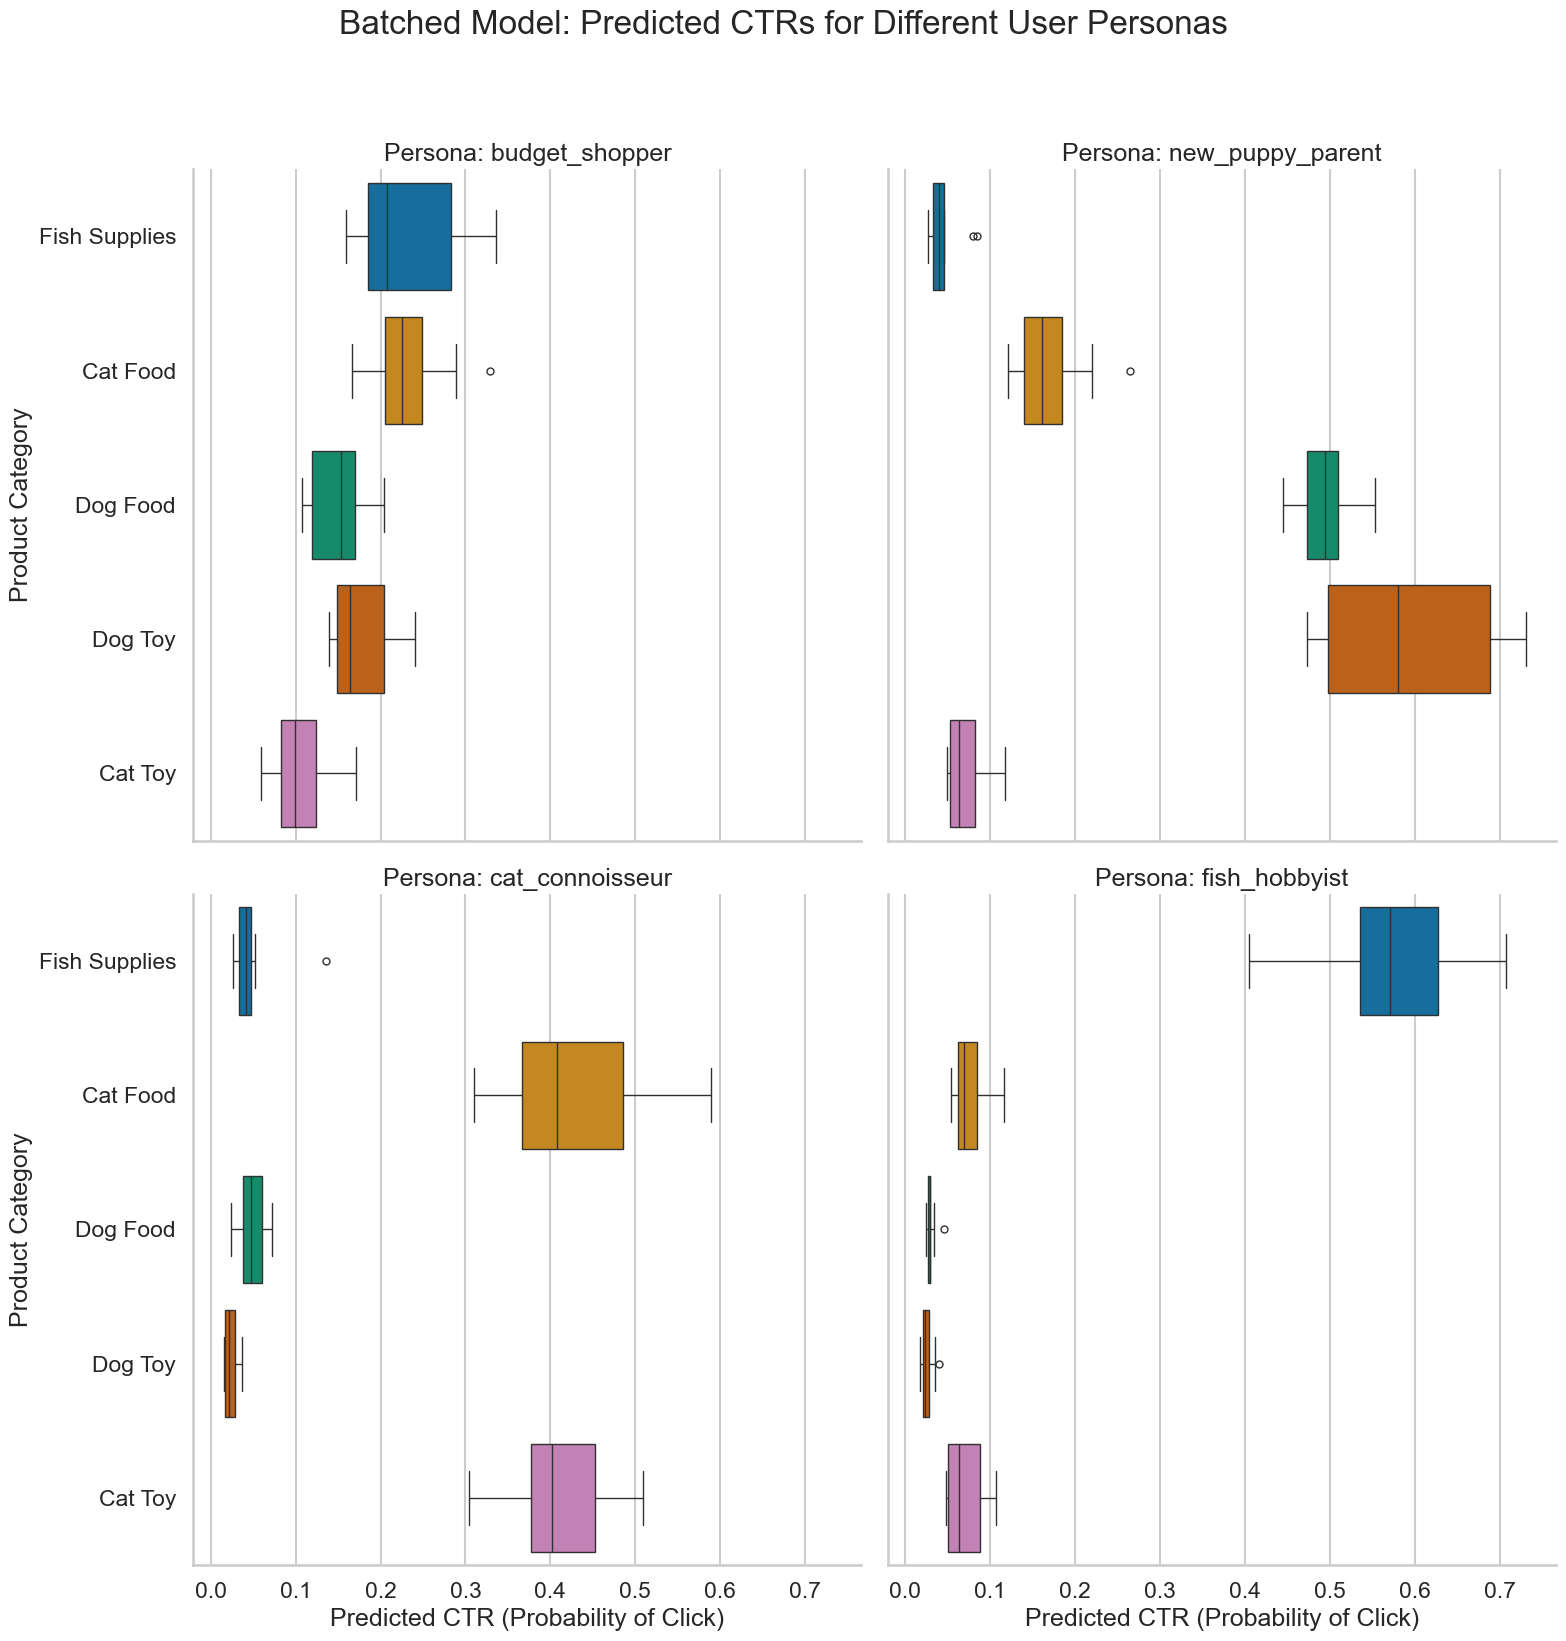

In [11]:
def get_batch_model_predictions(model, user_id, n_products, device):
    """Gets the model's predicted CTR for all products for a given user."""
    model.eval()
    with torch.no_grad():
        user_tensor = torch.tensor([user_id] * n_products, dtype=torch.long).to(device)
        product_tensor = torch.tensor(range(n_products), dtype=torch.long).to(device)
        scores = model(user_tensor, product_tensor).squeeze().cpu().numpy()
    return scores

# Find one user for each persona
persona_representatives = {p: u for u, p in reversed(list(sim.user_to_persona_map.items()))}

# Get predictions for each representative user
pred_data = []
for persona, user_id in persona_representatives.items():
    scores = get_batch_model_predictions(batch_model, user_id, sim.n_products, device)
    for prod_id, score in enumerate(scores):
        pred_data.append({
            'persona': persona,
            'category': sim.products.loc[prod_id, 'category'],
            'predicted_ctr': score
        })
pred_df = pd.DataFrame(pred_data)

# --- Plotting with catplot to match the target image ---
sns.set_style("whitegrid")
sns.set_context("talk")

g = sns.catplot(
    data=pred_df, 
    x='predicted_ctr', 
    y='category', 
    col='persona',
    kind='box',
    col_wrap=2,
    height=8, 
    aspect=1,
    palette='colorblind',
    order=['Fish Supplies', 'Cat Food', 'Dog Food', 'Dog Toy', 'Cat Toy'] # Match y-axis order
)

g.fig.suptitle('Batched Model: Predicted CTRs for Different User Personas', y=1.03, fontsize=24)
g.set_axis_labels('Predicted CTR (Probability of Click)', 'Product Category')
g.set_titles("Persona: {col_name}")
g.fig.tight_layout(rect=[0, 0, 1, 1])
plt.show()

#### **Interpreting the Results**

The plots in the figure above provide a clear visual summary of what our model has learned.

*   **For the `new_puppy_parent`**, the boxes for 'Dog Toy' and 'Dog Food' are shifted significantly to the right, indicating the model predicts a high CTR for these categories. Conversely, the predictions for cat-related items are low.
*   **For the `cat_connoisseur`**, the pattern is perfectly reversed. The model has correctly learned that this persona strongly prefers 'Cat Food' and 'Cat Toy'.
*   **For the `fish_hobbyist`**, the model shows overwhelming confidence in 'Fish Supplies', with predicted CTRs far exceeding any other category.
*   **For the `budget_shopper`**, the predictions are more moderate and spread out, correctly capturing the more generalist nature of this persona as defined in our simulation.

The visualization confirms that our baseline model, while static, has successfully learned the underlying preference structure from our noisy, historical data. It provides a strong, reliable point of comparison against which we can measure more advanced techniques.

### **1.5 Chapter Summary and Transition**

In this chapter, we have taken the critical first steps in our journey. We constructed a realistic simulation of an e-commerce environment, a crucial tool for offline experimentation. Using data from this simulation, we built and trained a standard, powerful baseline: an "Embedding + MLP" deep learning recommender using PyTorch.

While this model successfully learns from historical data, our critical analysis revealed its profound limitations in a dynamic, real-world setting:
1.  **The Cold-Start Problem:** It is blind to new users and new products.
2.  **Slow Adaptation:** It cannot keep up with changing user tastes.
3.  **Lack of Exploration:** It gets trapped in feedback loops, leading to stale and sub-optimal recommendations.

These are not minor issues; they are fundamental flaws stemming from the batched learning paradigm itself. The core problem is that the model is a **passive learner**. It is trained offline on a static dataset.

To overcome these challenges, we need a paradigm shift. We need a system that is an **active, online learner**. A system that learns from every single interaction, in real-time. A system that can quantify its own uncertainty and use that uncertainty to drive intelligent exploration.

This brings us to the **explore-exploit dilemma**, a central concept in reinforcement learning. How should a system balance *exploiting* its current knowledge to get immediate rewards (recommending the product with the highest known CTR) with *exploring* uncertain options to gain new knowledge that might lead to better rewards in the future?

Solving this dilemma is the key to creating a truly adaptive recommender. In the next chapter, we will introduce our first tool for tackling this problem head-on: the **Contextual Bandit**. We will leave the world of static, batched training behind and enter the exciting realm of continuous, interactive learning.